<a href="https://colab.research.google.com/github/abhinandanarya06/OCR/blob/master/Research_Notebook_on_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OCR Model Training**




###**Installing and Importing Required Libraries**


---



1. OpenCV - Image Processing Library
2. Tensorflow 2.0 - Machine learning Library

In [0]:
!pip3 install tensorflow==2.0rc1 # Tensorflow 2.O is stable version currently

from IPython.display import clear_output
import cv2 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

clear_output()

###**Getting The DATASET from the repository**


---


This will clone git repository. The hierarchy of this repository as shown below:

          OCR -+-> data -----+--> a
               |             +--> b
               +-> other     :
                   files     :
                             +--> noise
                             

In [3]:
!git clone https://github.com/abhinandanarya06/OCR.git

Cloning into 'OCR'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 19471 (delta 31), reused 57 (delta 13), pack-reused 19346
Receiving objects: 100% (19471/19471), 88.58 MiB | 32.70 MiB/s, done.
Resolving deltas: 100% (13279/13279), done.
Checking out files: 100% (48543/48543), done.


###**Function to show image**


---


"***imshow(image)***" function show image given as parameter

In [0]:
def imshow(image):
  plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()

###**Mapping Letters classes to numbers**
Keywords contains letters with appropriate index number mapping

In [0]:
keywords = [chr(c) for c in range(ord('a'), ord('z')+1)]
cap = ['A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'Q', 'R', 'T']
keywords = keywords + cap
keywords = keywords + ['noise']

In [6]:
print('No of text classification classes taken : ', len(keywords))

No of text classification classes taken :  41


###**Preparing Data for Training**

---
Using Tensorflow input data pipeline API (tf.data)


In [0]:
data_images = list()
labels = list()
i = 0
for c in keywords:
    path = 'OCR/data/{}/'.format(c) # IF YOU WANT TO GET DATA FROM OTHER PATH,
    files = os.listdir(path)        # THEN PLEASE MODIFY "path" VARIABLE ACCORDINGLY
    for name in files:
        img = cv2.imread(path+name, 0)
        try:
            img = cv2.resize(img, (30, 30), interpolation = cv2.INTER_AREA)
        except:
            continue
        img = img / np.max(img.reshape(900)) # Pixel feature normalization
        data_images.append([img])
        labels.append(i)
    i += 1


**Converting data to numpy array for reshaping**

In [0]:
data_images = np.array(data_images)
labels = np.array(labels)

DATASET_SIZE = labels.shape[0]
IMAGE_DATA_SHAPE = (DATASET_SIZE, 30, 30, 1)

data_images = data_images.reshape(IMAGE_DATA_SHAPE)

In [14]:
print('Image Data Shape : ', data_images.shape)
print('Labels Data Shape : ', labels.shape)

Image Data Shape :  (48528, 30, 30, 1)
Labels Data Shape :  (48528,)


**Converting to tf.data.Dataset type**

---



In [0]:
BATCH_SIZE = 1000

dataset = tf.data.Dataset.from_tensor_slices((data_images, labels))
dataset = dataset.shuffle(DATASET_SIZE)

VAL_SIZE = int(DATASET_SIZE * 0.2)

val_data = dataset.take(VAL_SIZE).batch(VAL_SIZE)
train_data = dataset.batch(BATCH_SIZE)

**Looking into dataset**

---



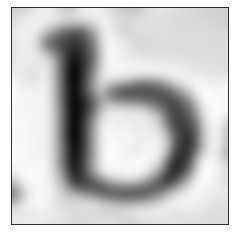

             b



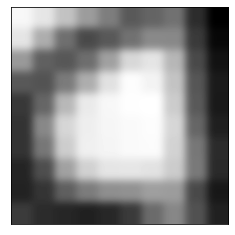

             noise



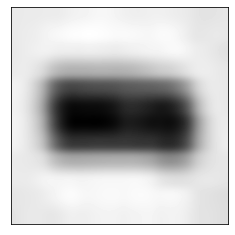

             noise



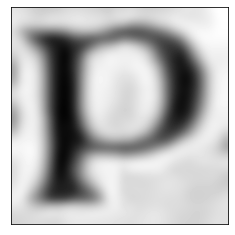

             p



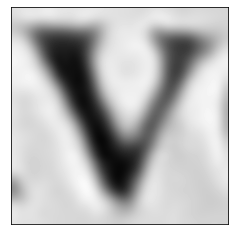

             v



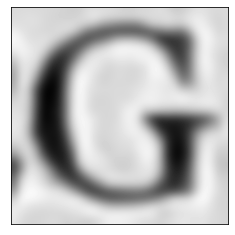

             G



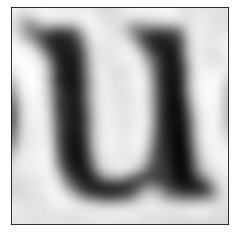

             u



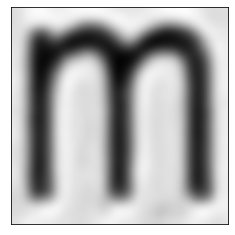

             m



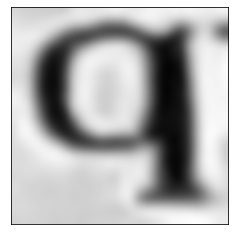

             q



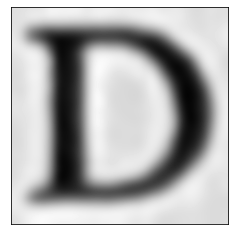

             D



In [16]:
for img, label in train_data.take(10):
  imshow(img[0].numpy().reshape((30, 30))*255)
  print(' '*12, keywords[label[0]], end='\n\n')


###**Model Architecture**


---


Layer Sequence (Sequencial Model) : 


1.   Conv2D Layer
2.   Flatten Operation
3.   Dense Layer with 200 units
4.   10% neuron Dropout Operation
5.   Dense Layer with keyword length units




In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (5, 5), activation='relu', input_shape = (30, 30, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(keywords))
])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 8)         208       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               1081800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 41)                8241      
Total params: 1,090,249
Trainable params: 1,090,249
Non-trainable params: 0
_________________________________________________________________


**Training starts with callback of early stopping with patience 3**

---



In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
history = model.fit(train_data, epochs=10, callbacks = [callback], validation_data=val_data)
clear_output()

**Training Analysis**

---



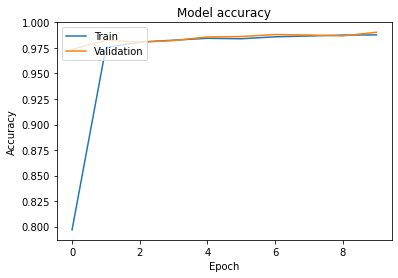

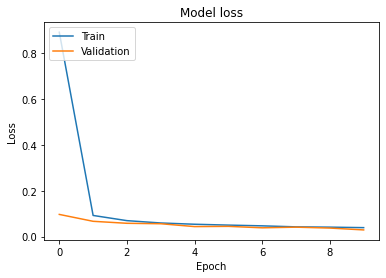

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



---


---





# **OCR Model Testing**


 

###**Saving the trained model**


---

'model' model is saved in current directory with name 'model.hd5'


In [0]:
model.save('model.h5')
clear_output()

### **Load Model**

---

if present in current directory

In [0]:
model = tf.keras.models.load_model('model.h5')

####**Adding Softmax Activation**

---



In [0]:
text_detector = tf.keras.Sequential(
    model,
    tf.keras.layers.Softmax()
)

### **OCR Deployment Demo (Testing Model)**


---



#####**Some Conventions**

In [0]:
X = 0   # X coordinate of the character in image space
Y = 1   # Y coordinate of the character in image space
POS = 1    # shows and return the (x,y) coordinate of image space
SHAPE = 2  # shows and return the (width, height) of character contour in image space
W = 0 # width of the character
H = 1 # height of the character

#####"***check_in(c, region)***" checks if character is present in the given region "*region*" of the image space

In [0]:
def check_in(c, region):
    x, y, w, h = region
    center_x = c[POS][X]+c[SHAPE][W]/2
    center_y = c[POS][Y]
    if (center_x > x-1 and center_x < x+w+1) and (center_y > y-1 and center_y < y+h+1):
        return True
    return False

#####"***get_region(c, regions)***" finds the region in the given list of regions "*regions*" in image space and return it

In [0]:
def get_region(c, regions):
    for region in regions:
        if check_in(c, region):
            return region
    return False

#####"***sort_chars(line)***" Function to sort characters in given line

In [0]:
def sort_chars(line):
    res = list()
    while len(line) > 0:
        mx = 100000
        m = 0
        for c in line:
            if c[POS][X] <= mx:
                mx = c[POS][X]
                m = c
        line.remove(m)
        res.append(m)
    return res

#####"***sort_lines_by_yval(lines)***" function sorts list of lines according to its y coordinate in image space

In [0]:
def sort_lines_by_yval(lines):
    res = list()
    while len(lines) > 0:
        mn = 100000
        m = 0
        for line in lines:
            if line[0][POS][Y] < mn:
              mn = line[0][POS][Y]
              m = line
        lines.remove(m)
        res.append(m)
    return res

#####"***group_chars_by_line(characters)***" Function to group characters in given image by lines

In [0]:
def group_chars_by_line(characters):
  lines = list()
  linei = 0
  while len(characters) > 0:
      m = characters[0]
      my = m[1][1]
      my_plus_h = m[1][1]+m[2][1]
      lines.append([m])
      for c in characters[1:]:
          if my <= c[POS][Y]+c[SHAPE][H]/2 and c[POS][Y]+c[SHAPE][H]/2 <= my_plus_h:
              if my > c[POS][Y]:
                  my = c[POS][Y]
              if my_plus_h < c[POS][Y]+c[SHAPE][H]:
                  my_plus_h = c[POS][Y]+c[SHAPE][H]
              lines[linei].append(c)
              characters.remove(c)
      lines[linei]= sort_chars(lines[linei])
      linei += 1
      characters.remove(m)
  return lines

#####"***apply_ocr(img)***" is the function that does actual ocr operation on image parameter to get text

In [0]:
def apply_ocr(img, text_detector):
    avg_text_height = 0 # will be assigned with Average Height of text character
    character_list = list() # will contain necessary text character to be extracted
    img = cv2.medianBlur(img,5)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,41,10) # will remove maximum noise and make image suitable for contour dt
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    black_map = img.copy()
    black_map[:, :] = 0
    i = 0
    for contour in contours:
        try:
            x,y,w,h = cv2.boundingRect(contour)
            try:
                cnt = img[y-2:y+h+2, x-2:x+w+2]
            except:
                cnt = img[y:y+h, x:x+w]
            cnt = cv2.resize(cnt, (30, 30), interpolation = cv2.INTER_AREA)
            cnt = cnt.reshape((1, 30, 30, 1))
            cnt = cnt / np.max(cnt.reshape(900))
            class_pred = np.argmax(text_detector.predict(cnt))
            if class_pred < 40:
                avg_text_height += h
                cv2.rectangle(black_map, (x-w//7,y), (x+w+w//7, y+h), 255, -1)
                character_list.append([keywords[class_pred], (x,y), (w,h)])
                i += 1
        except:
              continue
    avg_text_height /= i # Average Height of text character
    text = group_chars_by_line(character_list)
    text = sort_lines_by_yval(text)
    contours, hierarchy = cv2.findContours(black_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    regions = list() # will contain regions of words for grouping chars by word
    for contour in contours:
        region = cv2.boundingRect(contour)
        if region[SHAPE + H] <= avg_text_height*7:
          regions.append(region)
    del contours

    TEXT = ''
    for l in text:
        char = l[0]
        region = get_region(char, regions)
        if not region:
            continue
        for char in l:
            if not check_in(char, region):
                TEXT = TEXT + ' '
                r = get_region(char, regions)
                if not r:
                    continue
                region = r
            TEXT = TEXT + char[0]
        TEXT = TEXT + '\n'
    return TEXT

#####**Main Run Start Point**

---



* Before running this start point, Please check if 
 *test_image_path* variable have path to your own test images or not.
* If not, please modify the path variable

****************************** Text on 2.jpg ******************************


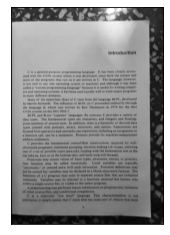

m
i
j
k j I p z e x i t y i a a h p m t t i x b r
j p
j
N
b
j
h
N
x
a T s k
iNm
T
e
N
j
y
x
Introductlon
x
s y
N
i
N
c Is a general purposec programmIng language It has been closely assocl s
ated mth the uNIx system here lt was developed sInce both the system and e
most of the programs that run on It are wrItten In c The lan age howevecr t t
l
ls not tIed to any one operatlng system or machIne and although It has been
lled a system programmIng language because It Is useful for wrltIng compll
ers and operatIng systecms It has been used equally well to wrlte major programs x
ln many dIfferent domaIns
Many of the Important Idecas of c stem from the language BcpL developecd
by M tln Rlchards The In uence of BcpL on c proceeded IndIrectly through
thec l guagec B whIch was wrltten by ken Thompson In l p o for the rst
Ix system on the DEc pDp v
y
BcpL and B are i typeless languages By contrast c provldes a varlety of j
data types The fundamental types are characters and lntecgers and doatIng


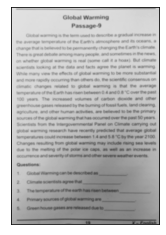

Global warmI ng
passage j
GIobai warming is the term used to describe a graduai increase in
the average temperature of the Ea h s atmosphere and its oceans a
change that is bei ieved to be permanentIy changing the Ea h s ci imate
There is great debate among many peopie and sometimes in the news
on whether gIobal warming is reai some cai i it a hoax But cIimate
scientists iooking at the data and facts agree the pianet is warming
whiIe many view the e ects of giobai warming to be more substantiai
and more rapidiy occurring than others do the scienti ic consensus on
cl imatic changes related to giobal warming is that the average
temperature of the Ea h has risen be een o and o B oc over the past
n oo years The increased voiumes of carbon dioxide and other
greenhouse gases reIeased by the burning of fossi i fueis Iand ciearing
agriculture and other human activities are beI ieved to be the prima
sources of the giobal warming that has occurred over the past bo years
scientists from the Inter

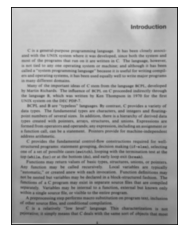

IntroductIon
c Is a gecneral purpose programmlng language It has becen closely assocl
ated mth the uNIx system wherec lt was developecd sInce both the system and
most of thec programs that run on I t are wrItten In c The language however
Is not tIed to any one operatIng system or machlne and although It has been
lled a systecm programmIng language because It Is useful for wrItIng compIl
ers d operatlng systems It has becen used equally well to wrItec major programs
m many dIfferecnt domaIns
Many of the Important ldecas of c stem from the language BcpL developecd
by M tln RIchards The ln uecnce of BcpL on c proceeded IndIrectly through
the l guage B whIch was wrItten by ken Thompson In l p o for the hrst
Ix system on the DEc pDp
BcpL and B are typeless languages By contrast c provIdes a varlety of
data typecs The fundamentaI types are characters and Integers and oatIng
pomt numbers of several sIzes In addItIon there Is a hlerarchy of decrIved data
t ecs created wIth poInters arrays stru

In [32]:
test_images_path = 'OCR/sample_test_image/' # IF YOU PLACE TEST IMAGE INSIDE OCR DIRECTORY,
                                            # THEN PLEASE MODIFY "test_images_path" variable


imgs = [f for f in os.listdir(test_images_path) if f.endswith('.jpg')]

for img in imgs:
    print('*'*30, 'Text on {}'.format(img), '*'*30)
    img = cv2.imread(test_images_path + img, 0)
    TEXT = apply_ocr(img, text_detector)
    imshow(img)
    print(TEXT)
    print('-'*80, '\n\n')